<a href="https://colab.research.google.com/github/arshika77/SAiDL_Summer_Assignment/blob/master/SAiDL_Q_4_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

For this multi-class classification task, initially the dataset was trained on a simple LSTM and multihead attention layer ( Not shown to keep notebook size affordable ) . The F1 micro score obtained was 0.52 and the F1 macro score obtained was 0.22 without the attention layer, and 0.54 and 0.28 (respectively) with the attention layer

To improve the performance and make use of a better architecture, the PyTorch-Transformers library was used. PyTorch-Transformers by HuggingFace is a library of state-of-the-art pre-trained models for Natural Language Processing (NLP). It has released only a few years back, bringing about NLP's "ImageNet moment". Basically, you can consider the use of pretrained models analogous to the concept of transfer learning used in Image detection/classification problems.

For this problem, we are using the DistilBert architecture. The pretrained model used is "distilbert-base-uncased". This model has 6-layers 768 hidden layer size, 12 attention-heads and around 66M parameters.

More information on DistilBert can be found in this paper: [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

From DistilBert, the F1 micro score obtained was 0.609 and the F1 macro core obtained was 0.609. Therefore, using "Transfer Learning" for the NLP task clearly performed better than writing our own architectures.

The training loss was 1.406 and validation loss was 1.285, indicating that there wasn't any significant overfitting

#Implementing DistilBert

In [2]:
!python -m pip install transformers

In [3]:
!unzip "Summer-Induction-Assignment-2020-master.zip" -d "data_directory"

Archive:  Summer-Induction-Assignment-2020-master.zip
a68e5defe587061f3116a1d57ea27751d7f5ce4f
   creating: data_directory/Summer-Induction-Assignment-2020-master/
   creating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/
   creating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/
  inflating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/README.md  
   creating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/data/
  inflating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/data/train.csv  
  inflating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/data/val.csv  
   creating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/RL PokeBattle/
  inflating: data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/RL PokeBattle/.gitattributes  
  inflating: data_directory/Summer-Induction-

##Importing Libraries

In [157]:
import numpy as np
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

##Taking Care of system logistics

In [5]:
#Disabling warnings. This is to prevent unnecessary printing of lines which leads to wastage of RAM

import logging
logging.basicConfig(level=logging.ERROR)

In [6]:
#Setting up the device
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'

In [7]:
print(device)

cuda:0


##Loading Data and creating the dataset

We will assume that Flair is decided by considering the title+post as the complete content. Thus, we need to concatentate the title and post coloumns as 'Content' in our model. We then set Content as type(str) and Flair as type(int)

In [8]:
# Import the csv into pandas dataframe and add the headers
train_df = pd.read_csv('data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/data/train.csv')

val_df = pd.read_csv('data_directory/Summer-Induction-Assignment-2020-master/Question 4.2/NLP Data/data/val.csv')

train_df['Content'] = train_df['Title'].str.cat(train_df['Post'], sep = " ")
train_df = train_df.drop(['Title','Post'],axis=1).astype(str)
#print(train_df['Content'].head())
val_df['Content'] = val_df['Title'].str.cat(val_df['Post'], sep = " ")
val_df = val_df.drop(['Title','Post'],axis=1).astype(str)


train_df['Content'] = train_df['Content'].apply(lambda x: x.replace('\\', ' '))
val_df['Content'] = val_df['Content'].apply(lambda x: x.replace('\\', ' '))

train_df['Flair'] = train_df['Flair'].astype(int)
val_df['Flair'] = val_df['Flair'].astype(int)


In [9]:
train_df.head()

,Flair,Content
0,10,netflix the family has been an amazing watch d...
1,0,all results are out is iiitm gwalior it branch...
2,0,which are the things you always buy made in in...
3,11,weekly coders hackers amp all tech related thr...
4,0,what are some good unknown companies to work a...


In [10]:
val_df.head()

,Flair,Content
0,0,travelling outside india for the first time be...
1,10,i am an american traveling to pune for work th...
2,7,roasting channels vs reaction channels why do ...
3,10,how the fake dadasaheb phalke awards game the ...
4,10,today congress has been greatly weakened or be...


In [11]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 1
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [12]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        content = str(self.data.Content[index])
        content = " ".join(content.split())
        inputs = self.tokenizer.encode_plus(
            content,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.Flair[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [13]:
# Creating the dataset and dataloader for the neural network

print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))

training_set = Triage(train_df, tokenizer, MAX_LEN)
validation_set = Triage(val_df, tokenizer, MAX_LEN)

TRAIN Dataset: (36547, 2)
VALIDATION Dataset: (9001, 2)


In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)

##Creating the neural network

In [152]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        config = DistilBertConfig(output_hidden_states = True ,output_attentions = True)
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased", config = config)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 15)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

    def get_attention(self,input_ids, attention_mask):
      output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
      attention = output[2][0][0]
      return attention.squeeze(0)[0]

In [153]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

##Training the neural network

In [163]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [164]:
# Calculating the F1 micro score
def calcuate_accu_micro(big_idx, targets):
  targets_cpu = targets.cpu()
  big_idx_cpu = big_idx.cpu()
  return torch.tensor(f1_score(targets_cpu.cpu(), big_idx_cpu.cpu(), average='micro'))

In [165]:
# Calculating the F1 macro score
def calcuate_accu_macro(big_idx, targets):
  targets_cpu = targets.cpu()
  big_idx_cpu = big_idx.cpu()
  return torch.tensor(f1_score(targets_cpu.cpu(), big_idx_cpu.cpu(), average='macro'))

In [166]:
# Defining the training function 

def train(epoch):
  
    sum_loss = 0
    total = 0

    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        sum_loss += loss.item()*targets.shape[0]
        total += targets.shape[0]
        big_val, big_idx = torch.max(outputs.data, dim=1)

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if _ % 500 == 1:
          val_loss, val_acc, val_f1_micro, val_f1_macro = validation_metrics(model, validation_loader)
          print("train loss %.3f, val loss %.3f, val accuracy %.3f, val f1 micro %.3f and val f1 macro %.3f" % (sum_loss/total, val_loss, val_acc, val_f1_micro,val_f1_macro))

    return 

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_f1_micro = 0.0
    sum_f1_macro = 0.0
    for  _,data in enumerate(valid_dl,0):

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)

        big_val, big_idx = torch.max(outputs.data, dim=1)
        correct += (big_idx == targets).float().sum()
        total += targets.shape[0]

        sum_loss += loss.item()*targets.shape[0]

        sum_f1_micro += (calcuate_accu_micro(big_idx, targets))*targets.shape[0]
        sum_f1_macro += (calcuate_accu_macro(big_idx, targets))*targets.shape[0]
    return sum_loss/total, correct/total, sum_f1_micro/total, sum_f1_macro/total

In [167]:
#Training

for epoch in range(EPOCHS):
    train(epoch)

train loss 2.709, val loss 2.675, val accuracy 0.334, val f1 micro 0.334 and val f1 macro 0.334
train loss 1.766, val loss 1.673, val accuracy 0.467, val f1 micro 0.467 and val f1 macro 0.467
train loss 1.695, val loss 1.590, val accuracy 0.483, val f1 micro 0.483 and val f1 macro 0.483
train loss 1.664, val loss 1.533, val accuracy 0.533, val f1 micro 0.533 and val f1 macro 0.533
train loss 1.627, val loss 1.510, val accuracy 0.545, val f1 micro 0.545 and val f1 macro 0.545
train loss 1.600, val loss 1.475, val accuracy 0.551, val f1 micro 0.551 and val f1 macro 0.551
train loss 1.582, val loss 1.463, val accuracy 0.545, val f1 micro 0.545 and val f1 macro 0.545
train loss 1.562, val loss 1.453, val accuracy 0.563, val f1 micro 0.563 and val f1 macro 0.563
train loss 1.543, val loss 1.427, val accuracy 0.564, val f1 micro 0.564 and val f1 macro 0.564
train loss 1.526, val loss 1.381, val accuracy 0.581, val f1 micro 0.581 and val f1 macro 0.581
train loss 1.512, val loss 1.383, val ac

Val f1 micro score - 0.609

Val f1 macro score - 0.609

## Saving/Reloading the model

In [168]:
# Saving the files for re-use

output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


In [172]:
!zip -r /content/models.zip /content/models

from google.colab import files
files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/vocab_distilbert_news.bin (deflated 49%)
  adding: content/models/pytorch_distilbert_news.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reloading the saved model

model = torch.load(output_model_file)

## Visualizing the attention weights

In [169]:
dataiter =  iter(validation_loader)
data = dataiter.next()

ids = torch.tensor(data['ids']).to(device)
mask = torch.tensor(data['mask']).to(device)
print(model(ids,mask))

tensor([[ 3.8116,  0.8209, -3.0468, -2.0901, -0.4731, -1.6371, -0.3517,  2.9455,
         -2.3004, -0.8704, -0.4374, -2.3882,  0.3521, -1.5496,  0.6789]],
       device='cuda:0', grad_fn=<AddmmBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [170]:
# First attention matrix

attention = model.get_attention(ids,mask)
print(attention)

tensor([[0.0048, 0.0037, 0.0034,  ..., 0.0109, 0.0074, 0.0261],
        [0.0081, 0.0290, 0.0110,  ..., 0.0098, 0.0042, 0.0065],
        [0.0203, 0.0200, 0.0076,  ..., 0.0066, 0.0055, 0.0028],
        ...,
        [0.0052, 0.0073, 0.0034,  ..., 0.0116, 0.0052, 0.0248],
        [0.0038, 0.0095, 0.0056,  ..., 0.0139, 0.0033, 0.0218],
        [0.0135, 0.0039, 0.0035,  ..., 0.0137, 0.0066, 0.1073]],
       device='cuda:0', grad_fn=<SelectBackward>)


Text(0.5, 1.0, 'Visualizing attention weights')

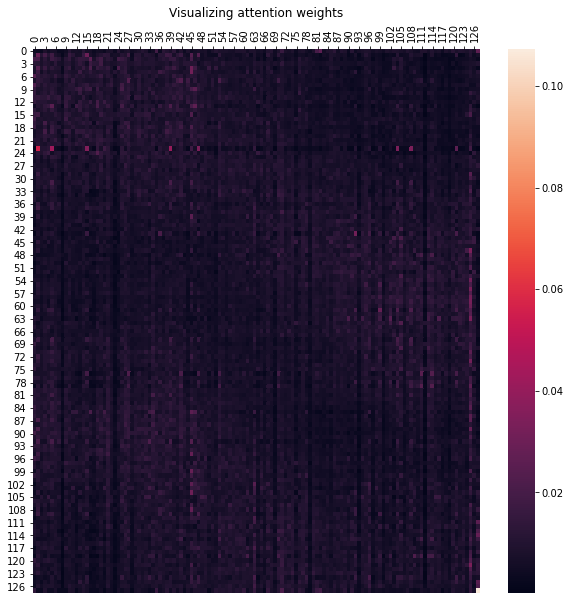

In [171]:
# Plotting heatmap of attention matrix for visualization

fig_size=(10,10)
fig, ax = plt.subplots(figsize=fig_size) 
ax = sns.heatmap(attention.cpu().detach().numpy(), annot=False)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Visualizing attention weights')

*Analysis of the attention weights:* 

As we can see, the attention weights are low in most cases. This indicates that the first attention layer was largely content-independent. However, there are around 3-4 patches of high content-dependency. For example, word 24 depends on word 0, word 6, word 14 etc.


In [173]:
data = dataiter.next()

ids = torch.tensor(data['ids']).to(device)
mask = torch.tensor(data['mask']).to(device)
print(model(ids,mask))

tensor([[ 2.7653, -1.5118, -0.8543, -0.7685, -0.9375, -1.8957, -1.6314,  0.9181,
         -2.6476,  0.5224,  3.9801, -2.4049, -1.3512, -1.5283,  0.5669]],
       device='cuda:0', grad_fn=<AddmmBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [174]:
# First attention matrix

attention = model.get_attention(ids,mask)
print(attention)

tensor([[0.0048, 0.0037, 0.0034,  ..., 0.0109, 0.0074, 0.0261],
        [0.0081, 0.0290, 0.0110,  ..., 0.0098, 0.0042, 0.0065],
        [0.0203, 0.0200, 0.0076,  ..., 0.0066, 0.0055, 0.0028],
        ...,
        [0.0052, 0.0073, 0.0034,  ..., 0.0116, 0.0052, 0.0248],
        [0.0038, 0.0095, 0.0056,  ..., 0.0139, 0.0033, 0.0218],
        [0.0135, 0.0039, 0.0035,  ..., 0.0137, 0.0066, 0.1073]],
       device='cuda:0', grad_fn=<SelectBackward>)


Text(0.5, 1.0, 'Visualizing attention weights')

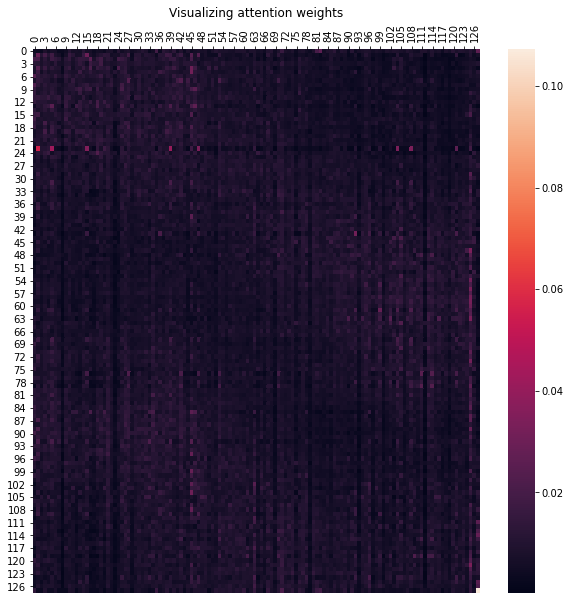

In [175]:
# Plotting heatmap of attention matrix for visualization

fig_size=(10,10)
fig, ax = plt.subplots(figsize=fig_size) 
ax = sns.heatmap(attention.cpu().detach().numpy(), annot=False)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Visualizing attention weights')

*Analysis of the attention weights:* 

As we can see, the attention weights are low in most cases. As we can see, the attention weights are low in most cases. This indicates that the first attention layer was largely content-independent. However, there are around 3-4 patches of high content-dependency. For example, word 102 depends on word 45, word 66, word 125 etc.



---


**Conclusion:** For this dataset, most of the weights were low. This could imply only very specific words have priority in deciding the flair in a post. This makes sense in the context of Reddit posts, as majority of the content is verbose description, while only a few factors in the entire post will be useful for classifying the post to its corresponding flair.



---

